# Gesture Recognition

Team : Anuprbha 

#### Objective:
    Build a model to recognise the following 5 hand gestures:
        
        Thumbs Up -- Increase the volume.
        Thumbs Down -- Decrease the volume.
        Left Swipe -- backwards 10 seconds.
        Right Swipe --  forward 10 seconds.
        Stop  -- Pause the movie.

#### Steps followed:
    1. Generator function
    2. CNN 3D models
    3. CNN+RNN ---> LSTM and GRU
    4. Transfer learning - mobilenet 

In [1]:
# Import libraries
import numpy as np
import os
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import pathlib
import random as rn
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf

import cv2
from scipy import misc
from PIL import Image
from PIL import ImageEnhance

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.applications import mobilenet


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)

In this block,read the folder names for training and validation and also set the `batch_size` here. 

In [3]:
# read csv files of train and val
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 40  #experiment with the batch size
image_height  = 120
image_width =120
channels =3
num_class =5 
num_frames = 12  # length of img_idx

In [4]:
# Folder path of train and val
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20   # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Generator
       Takes a batch of videos as input and takes care of preprocessing steps like cropping, resizing and normalization.

In [5]:
def generator(source_path, folder_list,batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # list of image numbers to use for a particular video
    img_idx = [i for i in range(3,27,2)] 
    while True:  
        t = np.random.permutation(folder_list)  # folders in train 
        num_batches = len(folder_list)//batch_size      # calculate the number of batches
        last_batch = len(folder_list)%batch_size     #left 
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,channels))
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_class)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted(os.listdir(str(source_path) +'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(str(source_path)+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]) #,cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if (image.shape[0]>300):
                        image=image[20:image.shape[0]-20,20:image.shape[1]-20,:]
                      
                    img_resize = cv2.resize(image, (image_height,image_width))
                   
                    #normalized_image= (img_resize - np.min(img_resize))/(np.max(img_resize)- np.min(img_resize))
                    batch_data[folder,idx,:,:,0] = (img_resize[:,:,0])/255     #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (img_resize[:,:,1])/255     #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (img_resize[:,:,2])/255     #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # yield the batch_data and the batch_labels, remember what does yield do
        # code for the remaining data points which are left after full batches
        if(last_batch!=0):
            batch_size =last_batch
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_class)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted(os.listdir(str(source_path) +'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(str(source_path)+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]) #,cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if (image.shape[0]>300):
                        image=image[20:image.shape[0]-20,20:image.shape[1]-20,:]
                      
                    img_resize = cv2.resize(image, (image_height,image_width))
                    
                    #normalized_image= (img_resize - np.min(img_resize))/(np.max(img_resize)- np.min(img_resize))
                    batch_data[folder,idx,:,:,0] = (img_resize[:,:,0])/255     #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (img_resize[:,:,1])/255     #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (img_resize[:,:,2])/255     #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                last_batch = 0
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
      
  


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Visualize the data :
        Lets visualize images from a folder after performing preprocessing steps.

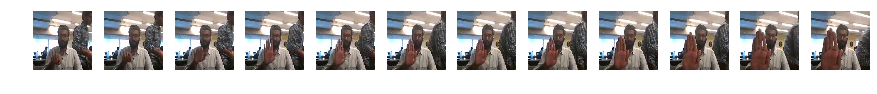

In [6]:
plt.figure(figsize=(15, 20))
t = np.random.permutation(train_doc)  # folders in train 
img_idx = [i for i in range(3,27,2)]
imgs = sorted(os.listdir(str(train_path) +'/'+ t[1 + (1*batch_size)].split(';')[0])) # read all the images in the folder
for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
    ax = plt.subplot(6, 12, idx + 1)
    image = cv2.imread(str(train_path)+'/'+ t[1 + (1*batch_size)].strip().split(';')[0]+'/'+imgs[item]) #,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    if (image.shape[0]>300):
        image=image[20:image.shape[0]-20,20:image.shape[1]-20,:]
                    
    img_resize = cv2.resize(image, (image_height,image_width))
    plt.imshow(img_resize)
    plt.axis("off")

## Model Building :
        
    'REducelronplateau' is used here to check on learning rate.

In [7]:
# Function for model building 
def fit_model(model):
    
    print("Total Params:", model.count_params())
    
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)

    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4 )  #, min_lr=0.001 )#,cooldown=1)     # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]


    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history


In [8]:
# Function to plot model performance
def plot_model(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model 1 : CNN 3D
        conv3D layers - 2
        Dense layers - 2
        kernel size - 3
        

In [9]:
input_shape=( num_frames, image_height,image_width,channels)

model_3D = Sequential()


model_3D.add(Conv3D(16,kernel_size=3,input_shape=input_shape,padding='same'))
model_3D.add(Activation('relu'))
model_3D.add(BatchNormalization())
model_3D.add(MaxPooling3D(pool_size=(2,2,2)))
#model_3D.add(Dropout(0.1))

model_3D.add(Conv3D(32,kernel_size=3,input_shape=input_shape,padding='same'))
model_3D.add(Activation('relu'))
model_3D.add(BatchNormalization())
model_3D.add(MaxPooling3D(pool_size=(2,2,2)))

model_3D.add(Flatten())
model_3D.add(Dense(64, activation='relu'))
model_3D.add(BatchNormalization())
model_3D.add(Dropout(0.1))

model_3D.add(Dense(64, activation='relu'))
model_3D.add(BatchNormalization())
model_3D.add(Dropout(0.1))

model_3D.add(Dense(num_class, activation='softmax'))
       
optimiser =  optimizers.Adam() #write your optimizer
model_3D.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3D.summary())       

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 12, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 12, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 6, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 6, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 60, 60, 32)     1

In [10]:
history_model_3D = fit_model(model_3D)

W0503 07:52:24.201628 140235640342336 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Total Params: 5550021
Source path =  Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.2968 - categorical_accuracy: 0.5173Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-05-0307_51_37.154116/model-00001-1.29678-0.51735-1.69137-0.34000.h5
17/17 [==============================] - 85s 5s/step - loss: 1.2968 - categorical_accuracy: 0.5173 - val_loss: 1.6914 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.7874 - categorical_accuracy: 0.7212
Epoch 00002: saving model to model_init_2021-05-0307_51_37.154116/model-00002-0.78737-0.72123-1.75986-0.31667.h5
17/17 [==============================] - 17s 980ms/step - loss: 0.7874 - categorical_accuracy: 0.7212 - val_loss: 1.7599 - val_categorical_accuracy: 0.3167 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.5737 - categorical_accuracy: 0.79

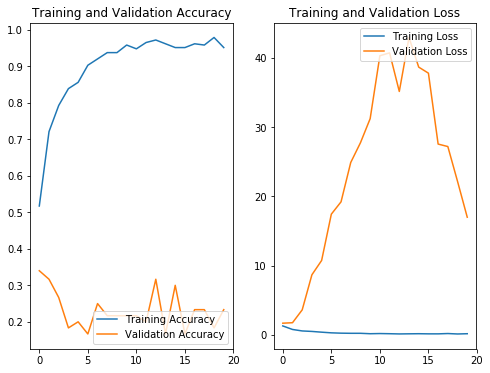

In [11]:
plot_model(history_model_3D)

Above model is overfitting.

## Model 2 : CNN 3D
        conv3D layers -3
        Dense layers - 2
        kernel size - 5

In [12]:
input_shape=( num_frames, image_height,image_width,channels)

model2_3D = Sequential()


model2_3D.add(Conv3D(16,kernel_size=5,input_shape=input_shape,padding='same'))
model2_3D.add(Activation('relu'))
model2_3D.add(BatchNormalization())
model2_3D.add(MaxPooling3D(pool_size=(2,2,2)))
#model_3D.add(Dropout(0.1))

model2_3D.add(Conv3D(32,kernel_size=5,input_shape=input_shape,padding='same'))
model2_3D.add(Activation('relu'))
model2_3D.add(BatchNormalization())
model2_3D.add(MaxPooling3D(pool_size=(2,2,2)))

model2_3D.add(Conv3D(64,kernel_size=5,input_shape=input_shape,padding='same'))
model2_3D.add(Activation('relu'))
model2_3D.add(BatchNormalization())
model2_3D.add(MaxPooling3D(pool_size=(2,2,2)))

model2_3D.add(Flatten())
model2_3D.add(Dense(128, activation='relu'))
model2_3D.add(BatchNormalization())
model2_3D.add(Dropout(0.25))

model2_3D.add(Dense(256, activation='relu'))
model2_3D.add(BatchNormalization())
model2_3D.add(Dropout(0.25))

model2_3D.add(Dense(num_class, activation='softmax'))
       
optimiser =  optimizers.Adam() #write your optimizer
# Compile the model
model2_3D.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# summary of the model
print (model2_3D.summary())       

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 12, 120, 120, 16)  6016      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 60, 60, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 6, 60, 60, 32)     64032     
_________________________________________________________________
activation_3 (Activation)    (None, 6, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 60, 60, 32)    

In [13]:
history_model2_3D = fit_model(model2_3D)

W0503 07:58:50.778477 140235640342336 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Total Params: 2205733
Source path =  Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.6181 - categorical_accuracy: 0.4133Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-05-0307_51_37.154116/model-00001-1.61805-0.41327-14.45340-0.24000.h5
17/17 [==============================] - 27s 2s/step - loss: 1.6181 - categorical_accuracy: 0.4133 - val_loss: 14.4534 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.9250 - categorical_accuracy: 0.6829
Epoch 00002: saving model to model_init_2021-05-0307_51_37.154116/model-00002-0.92501-0.68286-4.87621-0.23333.h5
17/17 [==============================] - 15s 897ms/step - loss: 0.9250 - categorical_accuracy: 0.6829 - val_loss: 4.8762 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.9412 - categorical_accuracy: 0.

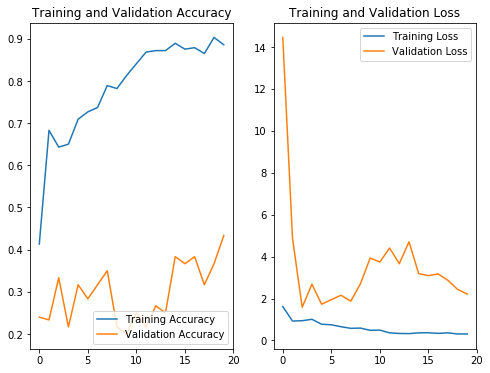

In [15]:
plot_model(history_model2_3D)

Model 2 is overfitting .

## Model 3 : CNN 3D
        conv3D layers -4
        Dense layers - 2
        kernel size - 5

In [17]:
input_shape=( num_frames, image_height,image_width,channels)

model3_3D = Sequential()


model3_3D.add(Conv3D(16,kernel_size=5,input_shape=input_shape,padding='same'))
model3_3D.add(Activation('relu'))
model3_3D.add(BatchNormalization())
model3_3D.add(MaxPooling3D(pool_size=(2,2,2)))
#model_3D.add(Dropout(0.1))

model3_3D.add(Conv3D(32,kernel_size=5,input_shape=input_shape,padding='same'))
model3_3D.add(Activation('relu'))
model3_3D.add(BatchNormalization())
model3_3D.add(MaxPooling3D(pool_size=(2,2,2)))
model_3D.add(Dropout(0.1))

model3_3D.add(Conv3D(64,kernel_size=5,input_shape=input_shape,padding='same'))
model3_3D.add(Activation('relu'))
model3_3D.add(BatchNormalization())
model3_3D.add(MaxPooling3D(pool_size=(2,2,2)))
model_3D.add(Dropout(0.1))

model3_3D.add(Flatten())
model3_3D.add(Dense(128, activation='relu'))
model3_3D.add(BatchNormalization())
model3_3D.add(Dropout(0.25))

model3_3D.add(Dense(256, activation='relu'))
model3_3D.add(BatchNormalization())
model3_3D.add(Dropout(0.25))

model3_3D.add(Dense(num_class, activation='softmax'))
       
optimiser =  optimizers.Adam() #write your optimizer
model3_3D.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3_3D.summary())       

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 12, 120, 120, 16)  6016      
_________________________________________________________________
activation_8 (Activation)    (None, 12, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 12, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 6, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 6, 60, 60, 32)     64032     
_________________________________________________________________
activation_9 (Activation)    (None, 6, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 6, 60, 60, 32)    

In [18]:
history_model3_3D = fit_model(model3_3D)

W0503 08:05:38.398416 140235640342336 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Total Params: 2205733
Source path =  Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.5352 - categorical_accuracy: 0.4314Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-05-0307_51_37.154116/model-00001-1.53519-0.43137-6.90231-0.18000.h5
17/17 [==============================] - 25s 1s/step - loss: 1.5352 - categorical_accuracy: 0.4314 - val_loss: 6.9023 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.1989 - categorical_accuracy: 0.5627
Epoch 00002: saving model to model_init_2021-05-0307_51_37.154116/model-00002-1.19889-0.56266-9.46418-0.23333.h5
17/17 [==============================] - 15s 892ms/step - loss: 1.1989 - categorical_accuracy: 0.5627 - val_loss: 9.4642 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.1400 - categorical_accuracy: 0.59

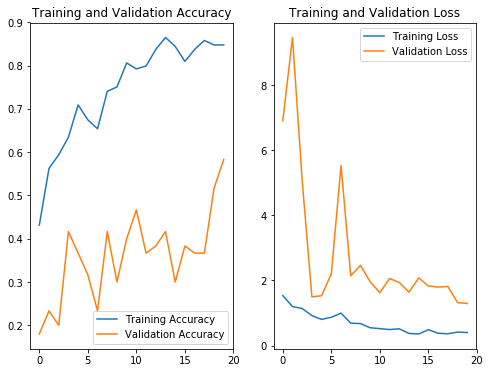

In [19]:
plot_model(history_model3_3D)

## Model 4 : CNN 3D
        conv3D layers -4
        Dense layers - 2
        kernel size - 5
        And added more dropouts

In [58]:
input_shape=( num_frames, image_height,image_width,channels)

model4_3D = Sequential()


model4_3D.add(Conv3D(16,kernel_size=5,input_shape=input_shape,padding='same'))
model4_3D.add(Activation('relu'))
model4_3D.add(BatchNormalization())
#model3_3D.add(MaxPooling3D(pool_size=(2,2,2)))
#model_3D.add(Dropout(0.1))

model4_3D.add(Conv3D(32,kernel_size=5,input_shape=input_shape,padding='same'))
model4_3D.add(Activation('relu'))
model4_3D.add(BatchNormalization())
model4_3D.add(MaxPooling3D(pool_size=(2,2,2)))

model4_3D.add(Conv3D(64,kernel_size=5,input_shape=input_shape,padding='same'))
model4_3D.add(Activation('relu'))
model4_3D.add(BatchNormalization())
model4_3D.add(MaxPooling3D(pool_size=(2,2,2)))
model4_3D.add(Dropout(0.1))

model4_3D.add(Conv3D(128,kernel_size=5,input_shape=input_shape,padding='same'))
model4_3D.add(Activation('relu'))
model4_3D.add(BatchNormalization())
model4_3D.add(MaxPooling3D(pool_size=(2,2,2)))
model4_3D.add(Dropout(0.1))

model4_3D.add(Flatten())
model4_3D.add(Dense(256, activation='relu'))
model4_3D.add(BatchNormalization())
model4_3D.add(Dropout(0.25))

model4_3D.add(Dense(512, activation='relu'))
model4_3D.add(BatchNormalization())
model4_3D.add(Dropout(0.25))

model4_3D.add(Dense(num_class, activation='softmax'))
       
optimiser =  optimizers.Adam() #write your optimizer
model4_3D.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4_3D.summary())  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 12, 120, 120, 16)  6016      
_________________________________________________________________
activation_3 (Activation)    (None, 12, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 12, 120, 120, 16)  64        
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 120, 120, 32)  64032     
_________________________________________________________________
activation_4 (Activation)    (None, 12, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 12, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 60, 60, 32)    

In [59]:
history_model4_3D = fit_model(model4_3D)

W0503 09:28:50.036993 140579375720256 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Total Params: 8861477
Source path =  Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.7186 - categorical_accuracy: 0.4238Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-05-0308_43_32.765918/model-00001-1.71857-0.42383-46.31524-0.21000.h5
17/17 [==============================] - 85s 5s/step - loss: 1.7186 - categorical_accuracy: 0.4238 - val_loss: 46.3152 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.0318 - categorical_accuracy: 0.6496
Epoch 00002: saving model to model_init_2021-05-0308_43_32.765918/model-00002-1.03184-0.64962-36.54052-0.26667.h5
17/17 [==============================] - 43s 3s/step - loss: 1.0318 - categorical_accuracy: 0.6496 - val_loss: 36.5405 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.0973 - categorical_accuracy: 0.6

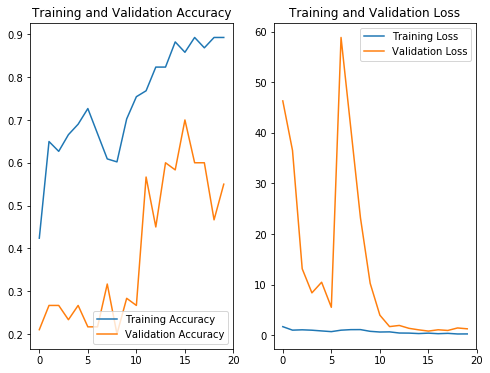

In [60]:
plot_model(history_model4_3D)

Above Cnn 3d model is performing good with 
    categorical accuracy = 87% and
    validation accuracy = 70%

## Model 5 CNN-RNN -> LSTM


In [9]:
input_shape=( num_frames, image_height,image_width,channels)
model_lstm = Sequential()

model_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=input_shape))
model_lstm.add(TimeDistributed(BatchNormalization()))
model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_lstm.add(TimeDistributed(BatchNormalization()))
model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
#model_lstm.add(Dropout(0.1))

model_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_lstm.add(TimeDistributed(BatchNormalization()))
model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
#model_lstm.add(Dropout(0.1))

model_lstm.add(TimeDistributed(Flatten()))

model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.25))

model_lstm.add(Dense(256,activation='relu'))
model_lstm.add(Dropout(0.25))
        
model_lstm.add(Dense(num_class, activation='softmax'))


optimiser = optimizers.Adam()
model_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_lstm.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 12, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 12, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 12, 30, 30, 64)    1

In [10]:
history_model_lstm = fit_model(model_lstm)

W0503 08:44:36.270974 140579375720256 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Total Params: 7497189
Source path =  Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.4738 - categorical_accuracy: 0.3846Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-05-0308_43_32.765918/model-00001-1.47380-0.38462-1.61077-0.21000.h5
17/17 [==============================] - 83s 5s/step - loss: 1.4738 - categorical_accuracy: 0.3846 - val_loss: 1.6108 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.1400 - categorical_accuracy: 0.5806
Epoch 00002: saving model to model_init_2021-05-0308_43_32.765918/model-00002-1.14003-0.58056-1.52192-0.26667.h5
17/17 [==============================] - 18s 1s/step - loss: 1.1400 - categorical_accuracy: 0.5806 - val_loss: 1.5219 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.0827 - categorical_accuracy: 0.5858


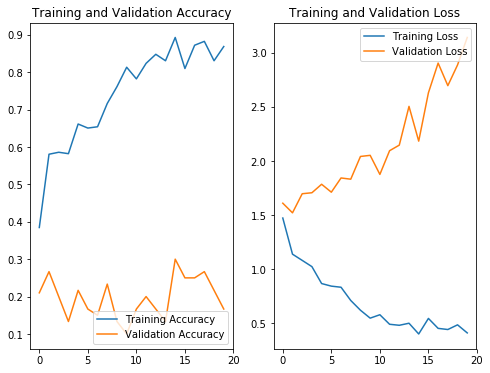

In [11]:
plot_model(history_model_lstm)

## Model 6 CNN-RNN -> GRU

In [12]:
input_shape=( num_frames, image_height,image_width,channels)
model_gru = Sequential()

model_gru.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=input_shape))
model_gru.add(TimeDistributed(BatchNormalization()))
model_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_gru.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_gru.add(TimeDistributed(BatchNormalization()))
model_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_gru.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_gru.add(TimeDistributed(BatchNormalization()))
model_gru.add(TimeDistributed(MaxPooling2D((2, 2))))

model_gru.add(TimeDistributed(Flatten()))

model_gru.add(GRU(128))
#model_lstm.add(Dropout(0.25))

model_gru.add(Dense(128,activation='relu'))
model_gru.add(Dropout(0.25))
        
model_gru.add(Dense(num_class, activation='softmax'))


optimiser = optimizers.Adam()
model_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 12, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 12, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_12 (TimeDis (None, 12, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 12, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 12, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 12, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 12, 30, 30, 64)   

In [13]:
history_model_gru = fit_model(model_gru)

W0503 08:51:43.038229 140579375720256 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Total Params: 5620709
Source path =  Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.3325 - categorical_accuracy: 0.4495Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-05-0308_43_32.765918/model-00001-1.33254-0.44947-2.47663-0.16000.h5
17/17 [==============================] - 24s 1s/step - loss: 1.3325 - categorical_accuracy: 0.4495 - val_loss: 2.4766 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.8184 - categorical_accuracy: 0.7161
Epoch 00002: saving model to model_init_2021-05-0308_43_32.765918/model-00002-0.81842-0.71611-2.52230-0.20000.h5
17/17 [==============================] - 14s 849ms/step - loss: 0.8184 - categorical_accuracy: 0.7161 - val_loss: 2.5223 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.8355 - categorical_accuracy: 0.70

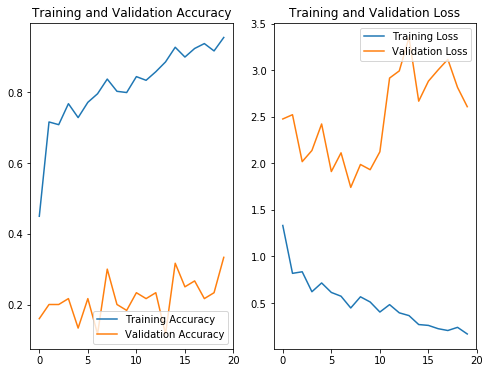

In [14]:
plot_model(history_model_gru)

## model 7 : Transfer learning --- Mobilenet + LSTM

Re-use MobileNet as it is quite lightweight , freeze the base layers and add LSTM and train. 

In [15]:
base_model=mobilenet.MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

input_shape=( num_frames, image_height,image_width,channels)

model_trans_lstm = Sequential()
model_trans_lstm.add(TimeDistributed(base_model,input_shape= input_shape))
        
model_trans_lstm.add(TimeDistributed(BatchNormalization()))
model_trans_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
model_trans_lstm.add(TimeDistributed(Flatten()))

model_trans_lstm.add(LSTM(128))
model_trans_lstm.add(Dropout(0.25))
        
model_trans_lstm.add(Dense(128,activation='relu'))
model_trans_lstm.add(Dropout(0.25))
        
model_trans_lstm.add(Dense(num_class, activation='softmax'))
        
        
optimiser = optimizers.Adam()
model_trans_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_trans_lstm.summary())

W0503 08:57:19.379855 140579375720256 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 12, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_21 (TimeDis (None, 12, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 12, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 12, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_______________________________________________________

In [16]:
history_mmodel_trans_lstm= fit_model(model_trans_lstm)

W0503 08:57:23.845322 140579375720256 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Total Params: 3840453
Source path =  Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.2947 - categorical_accuracy: 0.4691Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-05-0308_43_32.765918/model-00001-1.29467-0.46908-1.17171-0.58000.h5
17/17 [==============================] - 29s 2s/step - loss: 1.2947 - categorical_accuracy: 0.4691 - val_loss: 1.1717 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.4958 - categorical_accuracy: 0.8645
Epoch 00002: saving model to model_init_2021-05-0308_43_32.765918/model-00002-0.49585-0.86445-1.07251-0.63333.h5
17/17 [==============================] - 15s 907ms/step - loss: 0.4958 - categorical_accuracy: 0.8645 - val_loss: 1.0725 - val_categorical_accuracy: 0.6333 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.2934 - categorical_accuracy: 0.90

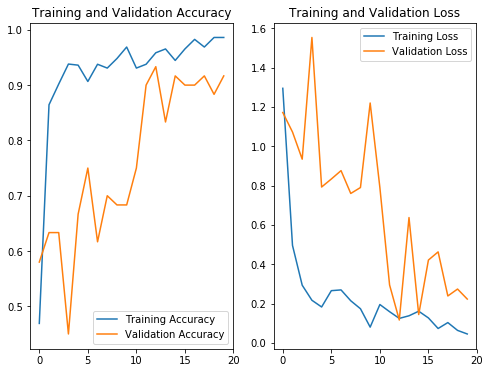

In [18]:
plot_model(history_mmodel_trans_lstm)

## model 8 : Transfer learning --- Mobilenet + GRU

In [19]:
base_model=mobilenet.MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

input_shape=( num_frames, image_height,image_width,channels)

model_trans_gru = Sequential()
model_trans_gru.add(TimeDistributed(base_model,input_shape= input_shape))
        
model_trans_gru.add(TimeDistributed(BatchNormalization()))
model_trans_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
model_trans_gru.add(TimeDistributed(Flatten()))

model_trans_gru.add(GRU(64))
model_trans_gru.add(Dropout(0.25))
        
model_trans_gru.add(Dense(64,activation='relu'))
model_trans_gru.add(Dropout(0.25))
        
model_trans_gru.add(Dense(num_class, activation='softmax'))
        
        
optimiser = optimizers.Adam()
model_trans_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_trans_gru.summary())

W0503 09:03:09.585497 140579375720256 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, 12, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_25 (TimeDis (None, 12, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 12, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 12, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [20]:
history_model_trans_gru = fit_model(model_trans_gru)

W0503 09:03:13.384597 140579375720256 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Total Params: 3446725
Source path =  Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.2669 - categorical_accuracy: 0.4736Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-05-0308_43_32.765918/model-00001-1.26692-0.47360-1.02357-0.67000.h5
17/17 [==============================] - 26s 2s/step - loss: 1.2669 - categorical_accuracy: 0.4736 - val_loss: 1.0236 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.4684 - categorical_accuracy: 0.8363
Epoch 00002: saving model to model_init_2021-05-0308_43_32.765918/model-00002-0.46843-0.83632-0.65119-0.81667.h5
17/17 [==============================] - 16s 926ms/step - loss: 0.4684 - categorical_accuracy: 0.8363 - val_loss: 0.6512 - val_categorical_accuracy: 0.8167 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.2956 - categorical_accuracy: 0.90

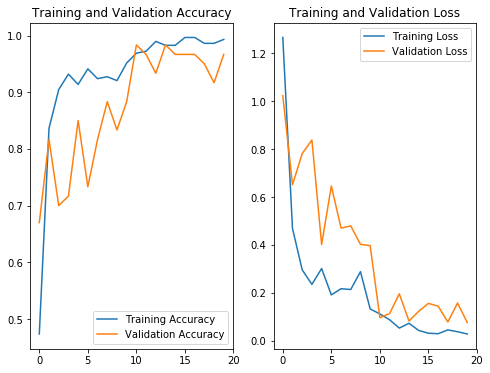

In [21]:
plot_model(history_model_trans_gru)

## Testing on the saved model

In [61]:
# Read images from validation folder
test_val = generator(val_path, val_doc, batch_size=10)
batch_data, batch_label=next(test_val)

Source path =  Project_data/val ; batch size = 10


In [62]:
batch_label

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [63]:
# load model
from keras.models import load_model

model = load_model("model-00020-0.28386-0.89273-1.29381-0.55000.h5") # cnn 3D model upto 70% accuracy

# prediction made by the model
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 3 0 4 4 3 0 0 1 3]
